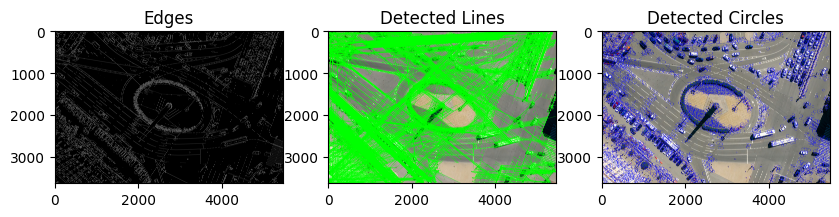

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('road.jpg')  # Replace with your image file
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray, 50, 150)

# Detect lines using Hough Transform
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 68, minLineLength=15, maxLineGap=250)

# Draw detected lines on the image
line_image = image.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Detect circles using Hough Circle Transform
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=30, param1=50, param2=30, minRadius=5, maxRadius=50)

# Draw detected circles
circle_image = image.copy()
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        cv2.circle(circle_image, (i[0], i[1]), i[2], (255, 0, 0), 2)

# Show results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1), plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB)), plt.title("Edges")
plt.subplot(1, 3, 2), plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB)), plt.title("Detected Lines")
plt.subplot(1, 3, 3), plt.imshow(cv2.cvtColor(circle_image, cv2.COLOR_BGR2RGB)), plt.title("Detected Circles")
plt.show()


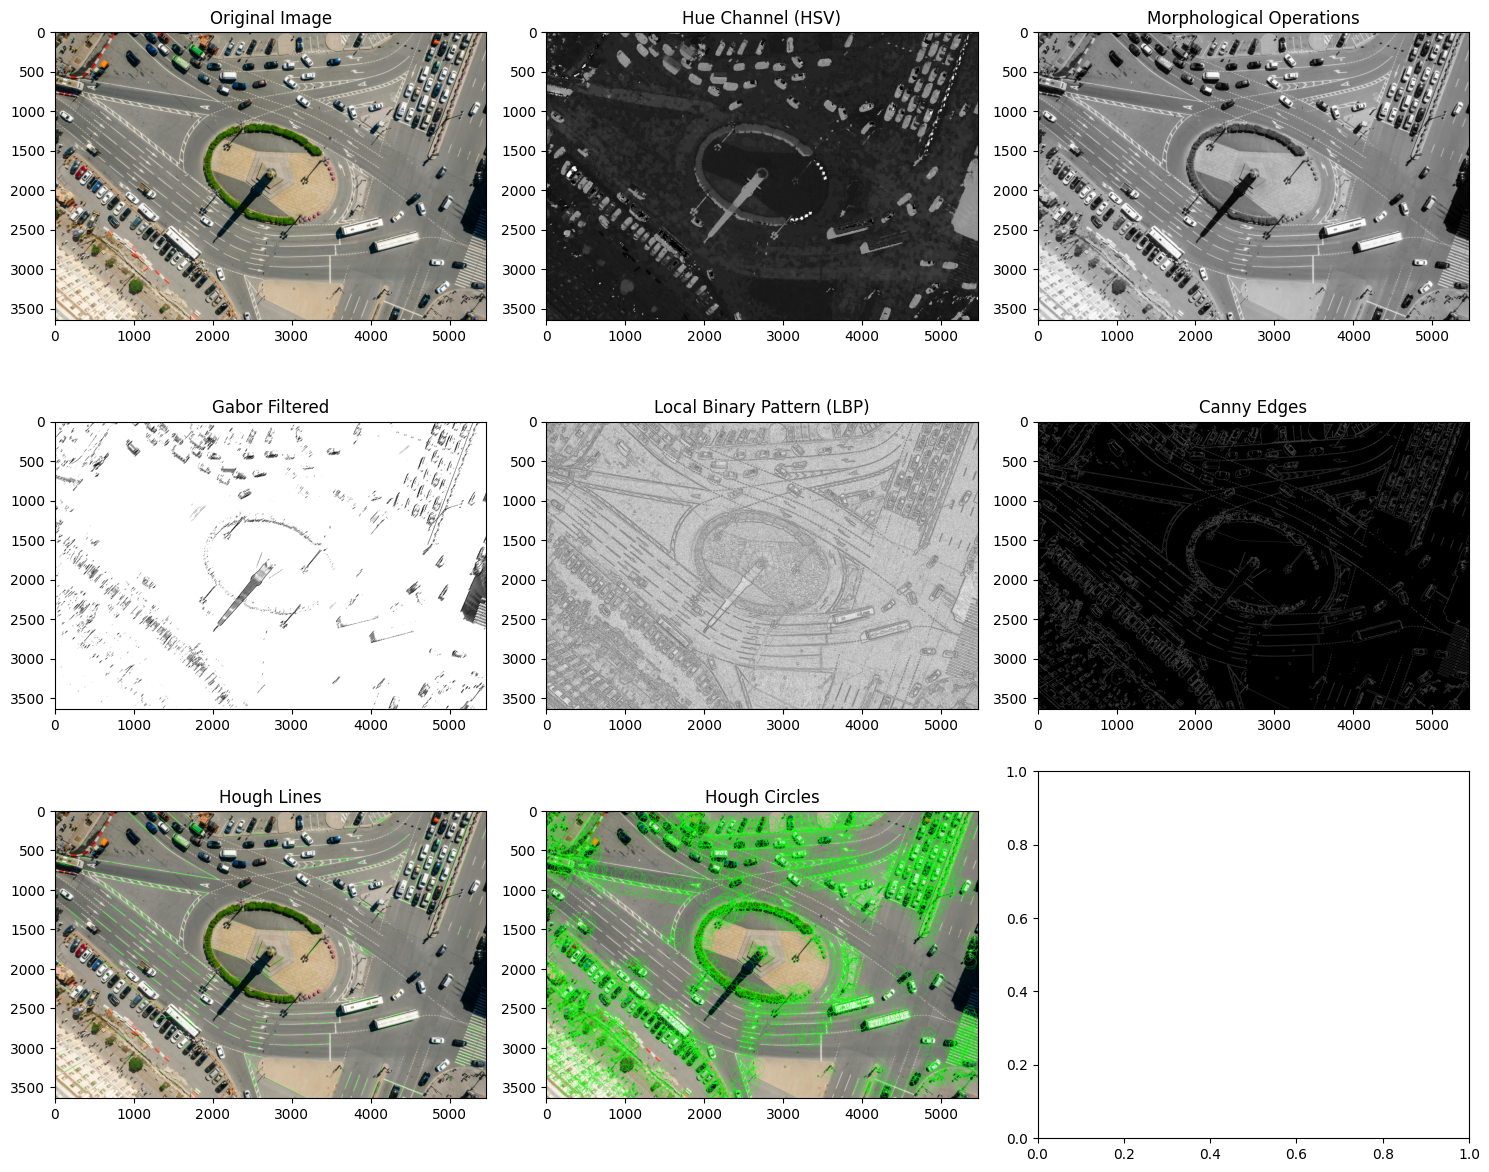

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

# Load image
image = cv2.imread("road.jpg")  # Replace with your image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 1. Convert to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
h_channel = hsv[:, :, 0]  # Extract Hue channel

# 2. Apply Morphological Operations
kernel = np.ones((5,5), np.uint8)
morph = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

# 3. Texture Analysis

## Gabor Filter
def apply_gabor(img, ksize=31, sigma=4, theta=np.pi/4, lambd=10, gamma=0.5):
    g_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, 0, ktype=cv2.CV_32F)
    filtered_img = cv2.filter2D(img, cv2.CV_8UC3, g_kernel)
    return filtered_img

gabor_filtered = apply_gabor(morph)

## Local Binary Pattern (LBP)
radius = 1
n_points = 8 * radius
lbp = local_binary_pattern(morph, n_points, radius, method="uniform")

# 4. Edge Detection before Hough Transform
edges = cv2.Canny(morph, 50, 150)

# 5. Hough Transform - Line Detection
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=50, minLineLength=50, maxLineGap=5)
line_image = np.copy(image)

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# 6. Hough Transform - Circle Detection
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1.2, minDist=30, param1=50, param2=30, minRadius=10, maxRadius=100)
circle_image = np.copy(image)

if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        cv2.circle(circle_image, (i[0], i[1]), i[2], (0, 255, 0), 2)

# Plot Results
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), axes[0, 0].set_title("Original Image")
axes[0, 1].imshow(h_channel, cmap='gray'), axes[0, 1].set_title("Hue Channel (HSV)")
axes[0, 2].imshow(morph, cmap='gray'), axes[0, 2].set_title("Morphological Operations")
axes[1, 0].imshow(gabor_filtered, cmap='gray'), axes[1, 0].set_title("Gabor Filtered")
axes[1, 1].imshow(lbp, cmap='gray'), axes[1, 1].set_title("Local Binary Pattern (LBP)")
axes[1, 2].imshow(edges, cmap='gray'), axes[1, 2].set_title("Canny Edges")
axes[2, 0].imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB)), axes[2, 0].set_title("Hough Lines")
axes[2, 1].imshow(cv2.cvtColor(circle_image, cv2.COLOR_BGR2RGB)), axes[2, 1].set_title("Hough Circles")

plt.tight_layout()
plt.show()


In [4]:
from ultralytics import settings
settings.reset()  # Clears cached dataset paths


In [8]:
import torch
import cv2
import numpy as np
import os
import shutil
from torchvision import datasets
from tqdm import tqdm
from ultralytics import YOLO

# Download FashionMNIST dataset
fashion_mnist = datasets.FashionMNIST(root="./data", train=True, download=True)
images, labels = fashion_mnist.data.numpy(), fashion_mnist.targets.numpy()

# Define class names (YOLO format)
class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

# Create YOLO dataset folders
dataset_path = "D:/CV & Image processing/Lab 6/fashion_mnist_yolo"
for folder in ["images/train", "images/val", "labels/train", "labels/val"]:
    os.makedirs(os.path.join(dataset_path, folder), exist_ok=True)

# Function to create bounding box around the main object
def get_bounding_box(image):
    # Threshold image
    _, thresh = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        return x, y, w, h
    return 0, 0, image.shape[1], image.shape[0]

# Convert dataset to YOLO format
def create_yolo_dataset(images, labels, split="train", num_samples=10000):
    for i in tqdm(range(num_samples), desc=f"Processing {split} data"):
        img = images[i]
        label = labels[i]
        
        # Get bounding box
        x, y, w, h = get_bounding_box(img)
        
        # Normalize coordinates (YOLO format requires relative values)
        h_img, w_img = img.shape
        x_center, y_center = (x + w / 2) / w_img, (y + h / 2) / h_img
        w, h = w / w_img, h / h_img

        # Save image
        img_path = f"{dataset_path}/images/{split}/{i}.jpg"
        cv2.imwrite(img_path, img)

        # Save label file (YOLO format: class x_center y_center width height)
        label_path = f"{dataset_path}/labels/{split}/{i}.txt"
        with open(label_path, "w") as f:
            f.write(f"{label} {x_center} {y_center} {w} {h}\n")

train_size = int(len(images) * 0.9)  # 90% train, 10% validation
val_size = len(images) - train_size  # Remaining for validation

create_yolo_dataset(images[:train_size], labels[:train_size], "train", train_size)
create_yolo_dataset(images[train_size:], labels[train_size:], "val", val_size)

# Define YAML file for YOLO training
yaml_content = f"""
train: dataset/images/train
val: dataset/images/val
nc: 10
names: {class_names}
"""

with open("dataset/fashion_mnist.yaml", "w") as f:
    f.write(yaml_content)

# Train YOLOv8 on Fashion MNIST
model = YOLO("yolov8n.pt")  # Load a pre-trained YOLOv8 model
model.train(data="dataset/fashion_mnist.yaml", epochs=10, imgsz=64)


Processing train data:   0%|          | 0/54000 [00:00<?, ?it/s]

Processing val data: 100%|██████████| 6000/6000 [00:03<00:00, 1918.63it/s]


New https://pypi.org/project/ultralytics/8.3.93 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.15  Python-3.12.4 torch-2.6.0+cpu CPU (AMD Ryzen 7 6800HS with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset/fashion_mnist.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=64, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False

RuntimeError: Dataset 'dataset/fashion_mnist.yaml' error  
Dataset 'dataset/fashion_mnist.yaml' images not found , missing path 'D:\Projects\DATA SCIENTIST_ASSIGNMENT-20250318T115327Z-001\datasets\dataset\dataset\images\val'
Note dataset download directory is 'D:\Projects\DATA SCIENTIST_ASSIGNMENT-20250318T115327Z-001\datasets'. You can update this in 'C:\Users\anand\AppData\Roaming\Ultralytics\settings.json'

In [15]:
model = YOLO("yolov8s.pt")  # Small, medium, large, or X variants


100%|██████████| 21.5M/21.5M [00:09<00:00, 2.34MB/s]


In [18]:
image_path = "road.jpg"  # Path to input image
image = cv2.imread(image_path)

# Perform object detection
results = model(image)  # Returns a list of Results objects

# Extract the first result
result = results[0]  # Get the first Results object

# Convert the result to an image with bounding boxes
annotated_frame = result.plot()

# Show the image with OpenCV
cv2.imshow("YOLO Detection", annotated_frame)
cv2.waitKey(0)
cv2.destroyAllWindows()



0: 448x640 40 cars, 2 buss, 115.5ms
Speed: 7.7ms preprocess, 115.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [19]:
import cv2
import numpy as np
from torchvision import models, transforms
from PIL import Image

image = Image.open("road.jpg")  
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
img_tensor = transform(image).unsqueeze(0)


In [21]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(cv2.imread("road.jpg"))
ss.switchToSelectiveSearchFast()  
regions = ss.process()[:2000]  # Top 2000 region proposals


AttributeError: module 'cv2' has no attribute 'ximgproc'

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import cv2

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reduce dataset size
train_size = 10000
test_size = 2000
x_train, y_train = x_train[:train_size], y_train[:train_size]
x_test, y_test = x_test[:test_size], y_test[:test_size]

# Reshape and normalize
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Function to generate region proposals (reduced number of windows)
def generate_regions(image, max_regions=5):
    regions = []
    coords = []
    
    for _ in range(max_regions):  # Limit number of regions per image
        w = np.random.choice([10, 14, 20])
        x, y = np.random.randint(0, 28 - w, size=2)
        roi = image[x:x+w, y:y+w]
        roi = cv2.resize(roi, (28, 28))  # Resize to standard size
        regions.append(roi)
        coords.append((x, y, w, w))
    
    return np.array(regions), coords

# Prepare training data
X_train_regions = []
y_train_labels = []
bounding_boxes = []

for i in range(len(x_train)):
    regions, coords = generate_regions(x_train[i], max_regions=3)  # Reduce regions
    for r, bbox in zip(regions, coords):
        X_train_regions.append(r)
        y_train_labels.append(y_train[i])
        bounding_boxes.append(bbox)

X_train_regions = np.array(X_train_regions).reshape(-1, 28, 28, 1)
y_train_labels = np.array(y_train_labels)
bounding_boxes = np.array(bounding_boxes)

# Define CNN for feature extraction
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu')
])

# Classification model
classifier = models.Sequential([
    cnn_model,
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # Classify digits 0-9
])

classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train classifier on reduced dataset
classifier.fit(X_train_regions, y_train_labels, epochs=3, batch_size=32, validation_split=0.1)

# Bounding Box Regression Model
bounding_box_model = models.Sequential([
    cnn_model,
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='linear')  # Predict (x, y, w, h)
])

bounding_box_model.compile(optimizer='adam', loss='mse')

# Train bounding box regressor on reduced dataset
bounding_box_model.fit(X_train_regions, bounding_boxes, epochs=3, batch_size=32, validation_split=0.1)


Epoch 1/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3624 - loss: 1.8004 - val_accuracy: 0.5827 - val_loss: 1.2342
Epoch 2/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 1.1510 - val_accuracy: 0.6473 - val_loss: 1.0292
Epoch 3/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6576 - loss: 0.9915 - val_accuracy: 0.6740 - val_loss: 0.9424
Epoch 1/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 16.3956 - val_loss: 3.4785
Epoch 2/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.1400 - val_loss: 2.9778
Epoch 3/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 2.7878 - val_loss: 2.7546
